In [1]:
import sys, os
import argparse
from os.path import join
import cv2
import dlib
import torch
import torch.nn as nn
from PIL import Image as pil_image
from tqdm import tqdm

from network.models import model_selection
from dataset.transform import xception_default_data_transforms, mesonet_default_data_transforms
from torch import autograd
import numpy
from torchvision import transforms
import attack_algos
import json
import matplotlib.pyplot as plt

In [2]:
video_path = "test_videos/Deepfakes/c23/videos/000_003.mp4"
print('Starting: {}'.format(video_path))
reader = cv2.VideoCapture(video_path)
videos = []
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))

# for i in range(num_frames):
#     _, img = reader.read()
#     videos.append(img)

Starting: test_videos/Deepfakes/c23/videos/000_003.mp4


In [3]:
video_path = "test_videos/Deepfakes/c23/videos/000_003.mp4"
if video_path.endswith('.mp4') or video_path.endswith('.avi'):
    print('single video')
print('Starting: {}'.format(video_path))
reader = cv2.VideoCapture(video_path)
video_fn = video_path.split('/')[-1].split('.')[0]+'.avi'

single video
Starting: test_videos/Deepfakes/c23/videos/000_003.mp4


In [4]:
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

In [5]:
fps = reader.get(cv2.CAP_PROP_FPS)
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))

In [6]:
face_detector = dlib.get_frontal_face_detector()

In [7]:
model = torch.load("faceforensics++_models_subset/face_detection/xception/all_c23.p")
model = model.cuda()

/root/miniconda3/envs/deepfake/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'network.models.TransferModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/deepfake/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/root/miniconda3/envs/deepfake/lib/python3.6/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original sourc

In [8]:
font_face = cv2.FONT_HERSHEY_SIMPLEX
thickness = 2
font_scale = 1

In [9]:
metrics = {
        'total_fake_frames' : 0,
        'total_real_frames' : 0,
        'total_frames' : 0,
        'percent_fake_frames' : 0,
        'probs_list' : [],
        'attack_meta_data' : [],
    }

In [29]:
reader = cv2.VideoCapture(video_path)
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
full_videos = []
full_shape = []
full_gray_images = []
full_faces = []
full_cropped_faces = []
full_processed_image = list()
for i in range(num_frames):
    _, image = reader.read()
    if image is None:
        break
    full_videos.append(image)
    # image size
    height, width = image.shape[:2]
    full_shape.append([height, width])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    full_gray_images.append(gray)
    faces = face_detector(gray, 1)

    if len(faces):
        face = faces[0]
    else:
        face = []

    full_faces.append(face)

    x, y, size = get_boundingbox(face, width, height)

    cropped_face = image[y:y+size, x:x+size]
#         full_cropped_faces.append(cropped_face)

    processed_image = preprocess_image(cropped_face, "xception", cuda = True)
    print(processed_image.shape)
    processed_image.require_grad=True
    full_processed_image.append(processed_image)
#     print(full_processed_image.shape)

final_result = torch.stack(full_processed_image, dim=0)

torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 139, 139])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 167, 167])
torch.Size([1, 3, 140, 140])
torch.Size([1, 3, 140, 140])
torch.Size([1,

KeyboardInterrupt: 

In [24]:
len(full_processed_image)

396

In [ ]:
fin

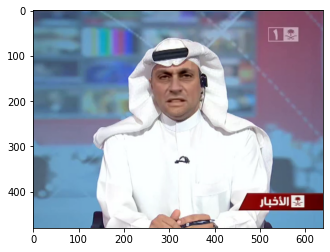

In [9]:
_, image = reader.read()
img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [10]:
output_path = 'tttttt'
height, width = image.shape[:2]
writer = cv2.VideoWriter(join(output_path, video_fn), fourcc, fps,
                                     (height, width)[::-1])
                                
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [32]:
if len(tt):
    print("1")

In [30]:
tt  = []

In [12]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

In [12]:
faces = face_detector(gray, 1)
face = faces[0]

x, y, size = get_boundingbox(face, width, height)
cropped_face = image[y:y+size, x:x+size]

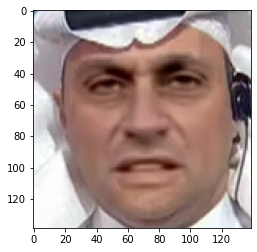

In [13]:
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))

In [13]:
def preprocess_image(image, model_type, cuda=True, legacy = False):
    """
    Preprocesses the image such that it can be fed into our network.
    During this process we envoke PIL to cast it into a PIL image.

    :param image: numpy image in opencv form (i.e., BGR and of shape
    :return: pytorch tensor of shape [1, 3, image_size, image_size], not
    necessarily casted to cuda
    """
    # Revert from BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Preprocess using the preprocessing function used during training and
    # casting it to PIL image
    if not legacy:
        # only conver to tensor here, 
        # other transforms -> resize, normalize differentiable done in predict_from_model func
        # same for meso, xception
        preprocess = xception_default_data_transforms['to_tensor']
    else:
        if model_type == "xception":
            preprocess = xception_default_data_transforms['test']
        elif model_type == "meso":
            preprocess = mesonet_default_data_transforms['test']

    preprocessed_image = preprocess(pil_image.fromarray(image))
    
    # Add first dimension as the network expects a batch
    preprocessed_image = preprocessed_image.unsqueeze(0)
    if cuda:
        preprocessed_image = preprocessed_image.cuda()

    preprocessed_image.requires_grad = True
    return preprocessed_image

In [15]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.netVggOne = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggTwo = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggThr = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFou = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFiv = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netScoreOne = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreTwo = torch.nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreThr = torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFou = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFiv = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)

        self.netCombine = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=5, out_channels=1, kernel_size=1, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

        self.load_state_dict({ strKey.replace('module', 'net'): tenWeight for strKey, tenWeight in torch.hub.load_state_dict_from_url(url='http://content.sniklaus.com/github/pytorch-hed/network-' + 'bsds500' + '.pytorch', file_name='hed-' + 'bsds500').items() })
    # end

    def forward(self, tenInput):
        tenInput = tenInput * 255.0
        tenInput = tenInput - torch.tensor(data=[104.00698793, 116.66876762, 122.67891434], dtype=tenInput.dtype, device=tenInput.device).view(1, 3, 1, 1)

        tenVggOne = self.netVggOne(tenInput)
        tenVggTwo = self.netVggTwo(tenVggOne)
        tenVggThr = self.netVggThr(tenVggTwo)
        tenVggFou = self.netVggFou(tenVggThr)
        tenVggFiv = self.netVggFiv(tenVggFou)

        tenScoreOne = self.netScoreOne(tenVggOne)
        tenScoreTwo = self.netScoreTwo(tenVggTwo)
        tenScoreThr = self.netScoreThr(tenVggThr)
        tenScoreFou = self.netScoreFou(tenVggFou)
        tenScoreFiv = self.netScoreFiv(tenVggFiv)

        tenScoreOne = torch.nn.functional.interpolate(input=tenScoreOne, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreTwo = torch.nn.functional.interpolate(input=tenScoreTwo, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreThr = torch.nn.functional.interpolate(input=tenScoreThr, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFou = torch.nn.functional.interpolate(input=tenScoreFou, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFiv = torch.nn.functional.interpolate(input=tenScoreFiv, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)

        return self.netCombine(torch.cat([ tenScoreOne, tenScoreTwo, tenScoreThr, tenScoreFou, tenScoreFiv ], 1))
    # end
# end


In [16]:
cropped_face.shape

(139, 139, 3)

In [17]:
def get_hed_face(face_data):
    # print(face_data.shape)
    tenInput = torch.FloatTensor((face_data/255.0).transpose(2, 0, 1))
    # print(tenInput.shape)
    netNetwork = Network().cuda().eval()
    intWidth = tenInput.shape[2]
    intHeight = tenInput.shape[1]
    tenOutput = netNetwork(tenInput.cuda().view(1, 3, intHeight, intWidth))[0, :, :, :].cpu()
    return tenOutput
    

In [63]:
print(cropped_face.max())

255


(139, 139, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


res:  torch.Size([1, 139, 139]) tensor(0.9803, grad_fn=<MaxBackward1>)
cropped face:  (139, 139, 3)
face mask:  (139, 139, 3)


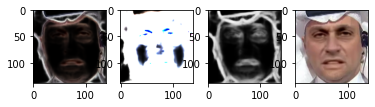

In [76]:
print(cropped_face.shape)
res = get_hed_face(cropped_face)
print("res: ", res.shape, res.max())
print("cropped face: ", cropped_face.shape)
face_mask = numpy.repeat(res.detach().numpy(), 3, 0).transpose(1, 2, 0)
print("face mask: ", face_mask.shape)

maskedface = cropped_face * face_mask


# 注意warining，数值在0-255范围要是整数，0-1范围要是浮点数，要不然会显示错误。
plt.subplot(141)
plt.imshow(maskedface[:,:,::-1]/255.0)
plt.subplot(142)
plt.imshow(maskedface)
plt.subplot(143)
plt.imshow(face_mask)
plt.subplot(144)
plt.imshow(cropped_face[:, :,::-1])
plt.show()
# cropped_face * res.detach().

In [21]:
print(cropped_face.shape, cropped_face.max())
processed_image = preprocess_image(cropped_face,"xception", cuda = True)
processed_image.require_grad=True
print(processed_image.shape, processed_image.max())

(139, 139, 3) 255
torch.Size([1, 3, 139, 139]) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


In [26]:
def predict_with_model(preprocessed_image, model, model_type, post_function=nn.Softmax(dim=1), cuda=True):
    """
    Adapted predict_for_model for attack. Differentiable image pre-processing.
    Predicts the label of an input image. Performs resizing and normalization before feeding in image.

    :param image: torch tenosr (bs, c, h, w)
    :param model: torch model with linear layer at the end
    :param post_function: e.g., softmax
    :param cuda: enables cuda, must be the same parameter as the model
    :return: prediction (1 = fake, 0 = real), output probs, logits
    """
    
    # Model prediction

    # differentiable resizing: doing resizing here instead of preprocessing

    
    if model_type == "xception":
        resized_image = nn.functional.interpolate(preprocessed_image, 
                                                size = (299, 299), mode = "bilinear", 
                                                align_corners = True)
        norm_transform = xception_default_data_transforms['normalize']
    normalized_image = norm_transform(resized_image)
    
    logits = model(normalized_image)
    output = post_function(logits)

    # Cast to desired
    _, prediction = torch.max(output, 1)    # argmax
    prediction = float(prediction.cpu().numpy())
    # print ("prediction", prediction)
    # print ("output", output)
    return int(prediction), output, logits

In [132]:
res_anly2 = []
def iterative_fgsm(input_img, model, model_type, cuda = True, 
                    max_iter = 500, alpha = 2/255.0, 
                    eps = 1/255.0, desired_acc = 0.99):
    
    temp = input_img.squeeze()
    netNetwork = Network().cuda().eval()
    with torch.no_grad():
        intWidth = temp.shape[2]
        intHeight = temp.shape[1]
        tenOutput = netNetwork(temp.cuda().view(1, 3, intHeight, intWidth))

    # print(tenOutput.shape)
    input_var = autograd.Variable(input_img, requires_grad=True)

    target_var = autograd.Variable(torch.LongTensor([0]))
    if cuda:
        target_var = target_var.cuda()
    iter_no = 0
    
    while iter_no < max_iter:
        
        prediction, output, logits = predict_with_model(input_var, model, model_type, cuda=cuda)    
        print("probilily :", output[0][0] - output[0][1])
        res_anly2.append(output[0][0] - output[0][1])
        if (output[0][0] - output[0][1]) > desired_acc:
            print(iter_no)
            break
            
        loss_criterion = nn.CrossEntropyLoss()
        loss = loss_criterion(logits, target_var)
        if input_var.grad is not None:
            input_var.grad.data.zero_() # just to ensure nothing funny happens
        loss.backward()

        step_adv = input_var.detach() - alpha * torch.sign(input_var.grad.detach())
        total_pert = step_adv - input_img
        # print(total_pert.shape)
        total_pert = total_pert * tenOutput
        total_pert = torch.clamp(total_pert, -eps, eps)
        
        input_adv = input_img + total_pert
        input_adv = torch.clamp(input_adv, 0, 1)
        
        input_var.data = input_adv.detach()

        iter_no += 1
        print(iter_no)
    l_inf_norm = torch.max(torch.abs((input_var - input_img))).item()
    print ("L infinity norm", l_inf_norm, l_inf_norm * 255.0)
    
    meta_data = {
        'attack_iterations' : iter_no,
        'l_inf_norm' : l_inf_norm,
        'l_inf_norm_255' : round(l_inf_norm * 255.0)
    }

    return input_var, meta_data

In [133]:
perturbed_image, attack_meta_data = iterative_fgsm(processed_image, model, "xception", True)

probilily : tensor(-1., device='cuda:0', grad_fn=<SubBackward0>)
1
probilily : tensor(-0.8202, device='cuda:0', grad_fn=<SubBackward0>)
2
probilily : tensor(0.4218, device='cuda:0', grad_fn=<SubBackward0>)
3
probilily : tensor(0.9940, device='cuda:0', grad_fn=<SubBackward0>)
3
L infinity norm 0.003921598196029663 1.000007539987564


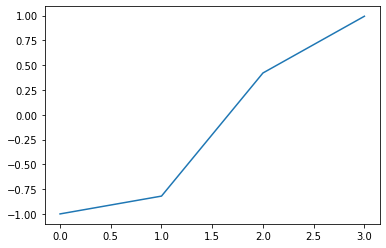

In [131]:
plt.plot(range(0,4), res_anly2)

In [62]:
masked_img = perturbed_image.squeeze().cpu().detach().numpy().transpose(1,2,0)

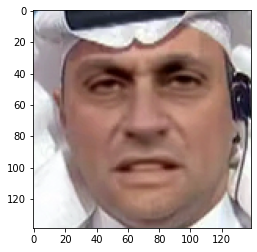

In [56]:
plt.imshow(masked_img)

In [27]:
import PIL
import PIL.Image

img = PIL.Image.open('./demo_images/sample.png')
# 使用Numpy将PIL对象转为矩阵时，通道数会变为（高度h、宽度w、通道数c）
# 参考链接 https://blog.csdn.net/suoluo_2020/article/details/125230593
tenInput = torch.FloatTensor(numpy.ascontiguousarray(numpy.array(img).astype(numpy.float32) * (1.0 / 255.0)))
# print(numpy.array(img)[])

In [25]:
tenInput.shape

torch.Size([320, 480, 3])

In [ ]:
def create_adversarial_video(video_path, model_path, model_type, output_path,
                            start_frame=0, end_frame=None, attack="iterative_fgsm", 
                            compress = True, cuda=True, showlabel = True):
    """
    Reads a video and evaluates a subset of frames with the a detection network
    that takes in a full frame. Outputs are only given if a face is present
    and the face is highlighted using dlib.
    :param video_path: path to video file
    :param model_path: path to model file (should expect the full sized image)
    :param output_path: path where the output video is stored
    :param start_frame: first frame to evaluate
    :param end_frame: last frame to evaluate
    :param cuda: enable cuda
    :return:
    """
    print('Starting: {}'.format(video_path))

    # Read and write
    reader = cv2.VideoCapture(video_path)

    video_fn = video_path.split('/')[-1].split('.')[0]+'.avi'
    os.makedirs(output_path, exist_ok=True)

    if compress:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    else:
        fourcc = cv2.VideoWriter_fourcc(*'HFYU') # Chnaged to HFYU because it is lossless

    fps = reader.get(cv2.CAP_PROP_FPS)
    num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 得到视频总帧数
    writer = None

    # Face detector
    face_detector = dlib.get_frontal_face_detector()

    # Load model
    if model_path is not None:
        if not cuda:
            model = torch.load(model_path, map_location = "cpu")
        else:
            model = torch.load(model_path)
        print('Model found in {}'.format(model_path))
    else:
        print('No model found, initializing random model.')
    if cuda:
        print("Converting mode to cuda")
        model = model.cuda()
        for param in model.parameters():
            param.requires_grad = True
        print("Converted to cuda")

    # raise Exception()
    # Text variables
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 2
    font_scale = 1

    # Frame numbers and length of output video
    frame_num = 0
    assert start_frame < num_frames - 1
    end_frame = end_frame if end_frame else num_frames
    pbar = tqdm(total=end_frame-start_frame)

    metrics = {
        'total_fake_frames' : 0,
        'total_real_frames' : 0,
        'total_frames' : 0,
        'percent_fake_frames' : 0,
        'probs_list' : [],
        'attack_meta_data' : [],
    }

    while reader.isOpened():
        _, image = reader.read()
        if image is None:
            break
        frame_num += 1

        if frame_num < start_frame:
            continue
        pbar.update(1)

        # Image size
        height, width = image.shape[:2]

        # Init output writer
        if writer is None:
            writer = cv2.VideoWriter(join(output_path, video_fn), fourcc, fps,
                                     (height, width)[::-1])

            # writer = cv2.VideoWriter(join(output_path, video_fn), 0, 1,
            #                          (height, width)[::-1])

        # 2. Detect with dlib
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 参数1表示我们对图像进行向上采样1倍，这将使一切变的更大
        # 进而让我们检测出更多的人脸
        faces = face_detector(gray, 1)
        if len(faces):
            # 可能有多张脸选最大的
            # For now only take biggest face
            face = faces[0]

            # --- Prediction ---------------------------------------------------
            # Face crop with dlib and bounding box scale enlargement
            x, y, size = get_boundingbox(face, width, height)
            cropped_face = image[y:y+size, x:x+size]

            # 默认只将其从PIL转化为Tensor
            processed_image = preprocess_image(cropped_face, model_type, cuda = cuda)
            processed_image.require_grad=True
            # Attack happening here
            # white-box attacks
            if attack == "iterative_fgsm":
                perturbed_image, attack_meta_data = attack_algos.iterative_fgsm(processed_image, model, model_type, cuda)
            elif attack == "mask_iterative_fgsm":
                perturbed_image, attack_meta_data = attack_algos.iterative_fgsm_mask(processed_image, model, model_type, cuda)
            elif attack == "robust":
                perturbed_image, attack_meta_data = attack_algos.robust_fgsm(processed_image, model, model_type, cuda)
            elif attack == "carlini_wagner":
                perturbed_image, attack_meta_data = attack_algos.carlini_wagner_attack(processed_image, model_type, model, cuda)

            # black-box attacks
            elif attack == "black_box":
                perturbed_image, attack_meta_data = attack_algos.black_box_attack(processed_image, model, model_type, 
                    cuda, transform_set={}, desired_acc = 0.999999)
            elif attack == "black_box_robust":
                perturbed_image, attack_meta_data = attack_algos.black_box_attack(processed_image, model, 
                    model_type, cuda, transform_set = {"gauss_blur", "translation", "resize"})
            
            # Undo the processing of xceptionnet, mesonet Tensor back to PIL
            unpreprocessed_image = un_preprocess_image(perturbed_image, size)
            image[y:y+size, x:x+size] = unpreprocessed_image
            
            # TODO: 为什么不重新检测人脸？
            cropped_face = image[y:y+size, x:x+size]
            # 将PIL 转换为Tensor 并未进行其他操作
            processed_image = preprocess_image(cropped_face, model_type, cuda = cuda)
            prediction, output, logits = attack_algos.predict_with_model(processed_image, model, model_type, cuda=cuda)
            print (">>>>Prediction for frame no. {}: {}".format(frame_num ,output))

            # 该图片没有进行 preprocess_image 处理
            prediction, output = predict_with_model_legacy(cropped_face, model, model_type, cuda=cuda)
            print (">>>>Prediction LEGACY for frame no. {}: {}".format(frame_num ,output))

            label = 'fake' if prediction == 1 else 'real'
            if label == 'fake':
                metrics['total_fake_frames'] += 1.
            else:
                metrics['total_real_frames'] += 1.

            metrics['total_frames'] += 1.
            metrics['probs_list'].append(output[0].detach().cpu().numpy().tolist())
            metrics['attack_meta_data'].append(attack_meta_data)

            if showlabel:
                # Text and bb
                # print a bounding box in the generated video
                x = face.left()
                y = face.top()
                w = face.right() - x
                h = face.bottom() - y
                label = 'fake' if prediction == 1 else 'real'
                color = (0, 255, 0) if prediction == 0 else (0, 0, 255)
                output_list = ['{0:.2f}'.format(float(x)) for x in
                               output.detach().cpu().numpy()[0]]

                cv2.putText(image, str(output_list)+'=>'+label, (x, y+h+30),
                            font_face, font_scale,
                            color, thickness, 2)
                # draw box over face
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

        if frame_num >= end_frame:
            break

        writer.write(image)
    pbar.close()

    metrics['percent_fake_frames'] = metrics['total_fake_frames']/metrics['total_frames']

    with open(join(output_path, video_fn.replace(".avi", "_metrics_attack.json")), "w") as f:
        f.write(json.dumps(metrics))
    if writer is not None:
        writer.release()
        print('Finished! Output saved under {}'.format(output_path))
    else:
        print('Input video file was empty')